In [50]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np


data = pd.read_csv('Data/train_all_dummies.csv')
data.drop('Unnamed: 0', inplace=True, axis=1)

np.random.seed(42)

X,y = data.drop('diagnosed_diabetes', axis=1), data['diagnosed_diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

X_train

,age,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,sleep_hours_per_day,screen_time_hours_per_day,bmi,waist_to_hip_ratio,systolic_bp,diastolic_bp,...,income_level_Lower-Middle,income_level_Middle,income_level_Upper-Middle,smoking_status_Current,smoking_status_Former,smoking_status_Never,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed
57105,35,1,134,7.9,8.4,7.7,20.4,0.82,98,70,...,0,1,0,0,0,1,1,0,0,0
660816,64,4,72,5.2,8.0,8.5,22.9,0.81,137,66,...,0,0,1,0,0,1,0,1,0,0
295318,50,2,91,6.2,8.3,6.7,25.7,0.85,119,77,...,0,1,0,0,0,1,0,1,0,0
447035,61,3,116,4.7,7.3,5.9,32.0,0.94,134,74,...,0,0,0,1,0,0,0,1,0,0
106260,31,3,65,6.7,7.7,10.2,24.4,0.82,106,73,...,1,0,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525621,32,4,216,2.3,8.5,7.2,29.7,0.90,126,84,...,0,0,0,1,0,0,0,1,0,0
359213,54,2,89,6.2,6.4,7.0,26.5,0.87,113,71,...,1,0,0,0,1,0,1,0,0,0
196287,59,4,100,5.5,5.9,4.1,25.2,0.81,131,85,...,0,1,0,0,0,1,0,1,0,0
141263,60,1,65,6.2,6.9,3.5,31.9,0.91,124,78,...,1,0,0,0,0,1,0,0,0,1


# Metric Function

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    105549
         1.0       1.00      1.00      1.00    174451

    accuracy                           1.00    280000
   macro avg       1.00      1.00      1.00    280000
weighted avg       1.00      1.00      1.00    280000



{'accuracy': 1.0, 'roc_score': 1.0}

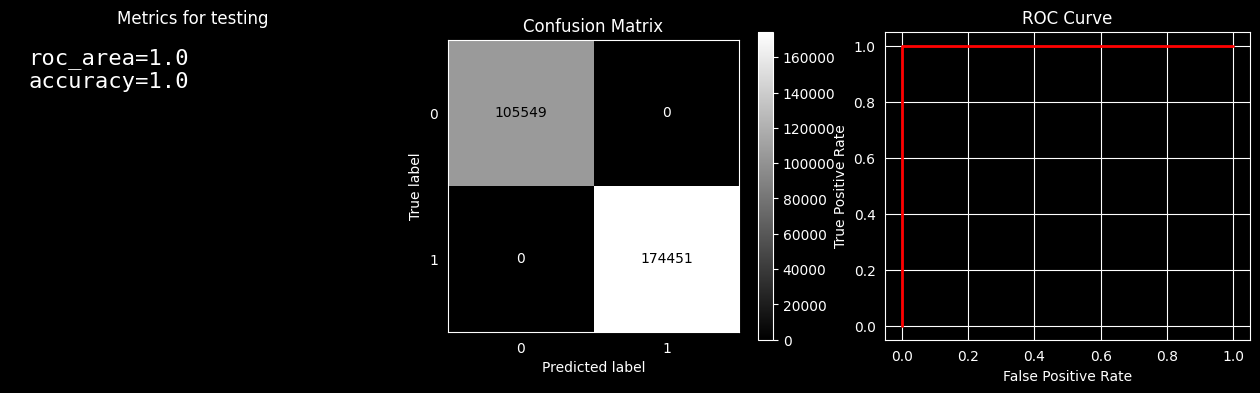

In [51]:
from matplotlib import pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, \
    roc_curve, classification_report


def metrics(preds:np.ndarray, probs:np.ndarray, lables:np.ndarray, method:str):
    cf_mtx = confusion_matrix(lables, preds)
    fpr, tpr, thresholds = roc_curve(lables, probs)
    roc_area = roc_auc_score(lables, probs)
    accuracy = accuracy_score(lables, preds)

    print(classification_report(lables, preds))

    text = f"{roc_area=}\n{accuracy=}"

    cf_mtx_disp = ConfusionMatrixDisplay(confusion_matrix=cf_mtx)
    roc_disp = RocCurveDisplay(fpr=fpr,tpr=tpr)

    fig, (ax_report, ax_matrix, ax_roc) = plt.subplots(1, 3, figsize=(16, 4))
    ax_report.text(
        x=0.05,
        y=0.95,
        s=text,
        family='monospace',
        fontsize=16,
        verticalalignment='top',
        transform=ax_report.transAxes)
    ax_report.set_title(f'Metrics for {method}')
    ax_report.axis('off')

    ax_matrix.set_title("Confusion Matrix")
    ax_matrix.grid(False)
    ax_matrix = cf_mtx_disp.plot(ax=ax_matrix, cmap='grey')

    ax_roc.set_title('ROC Curve')
    ax_roc.plot(fpr,tpr, linewidth=2, label='ROC Curve', color='red')
    ax_roc.set_xlabel('False Positive Rate')
    ax_roc.set_ylabel('True Positive Rate')


    return {"accuracy": accuracy, "roc_score": roc_area}


metrics(y_train,y_train,y_train, "testing")

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score

from typing import Literal


def ulitmate_objective_generator(scaler_name:Literal['standard', 'minmax', 'robust'], selector_name:Literal['RFE', 'Kbest'], model_name:Literal['Logistic', 'KNN', 'Forest', 'SVM'], features_quantity:int = 42):
    scaler_class = None
    model_class = None

    if scaler_name == 'standard':
        scaler_class = StandardScaler

    elif scaler_name == 'minmax':
        scaler_class = MinMaxScaler

    elif scaler_name == 'robust':
        scaler_class = RobustScaler

    if selector_name == 'RFE':
        selector_class = RFE
    elif selector_name == 'Kbest':
        selector_class = SelectKBest


    if model_name == 'Logistic':
        model_class = LogisticRegression
    elif model_name == 'KNN':
        model_class = KNeighborsClassifier
    elif model_name == 'Forest':
        model_class = RandomForestClassifier
    elif model_name == 'SVM':
        model_class = SVC


    def objective(trial):
        #Scalers
        nonlocal scaler_class, model_class
        model_params = {}
        scaler_params = {}

        if scaler_class is StandardScaler:

            scaler_params = {}

        if scaler_class is MinMaxScaler:
            clip = trial.suggest_categorical('scaler__clip', [True, False])

            scaler_params = {'clip': clip}

        if scaler_class is RobustScaler:
            with_centering=trial.suggest_categorical('scaler__with_centering', [True, False])
            quantile_range = trial.suggest_categorical('scaler__quantile_range', [(0.1, 0.9), (0.25, 0.75), (0.3, 0.7), (0.4, 0.6)])

            scaler_params = {'with_scaling': True, 'with_centering': with_centering, 'quantile_range': quantile_range}

         # Feature Selection
        if selector_class is RFE:
            n_features_to_select = trial.suggest_int('features_selector__n_features_to_select', 1, features_quantity)

        if selector_class is SelectKBest:
            k = trial.suggest_int('features_selector__k', 1, features_quantity)


        # Models
        if model_class is LogisticRegression:
            C = trial.suggest_float('classifier__C', 1e-3, 1e2, log=True)
            solver = trial.suggest_categorical('classifier__solver', ['lbfgs', 'liblinear', 'saga'])
            max_iter = trial.suggest_int('classifier__max_iter', 100, 2000)

            model_params = {'C': C, 'solver': solver, 'max_iter': max_iter}

        if model_class is KNeighborsClassifier:
            n_neighbors = trial.suggest_int("classifier__n_neighbors", 1, 80)
            weights = trial.suggest_categorical('classifier__weights', ['uniform', 'distance'])
            metric  = trial.suggest_categorical('classifier__metric', ['manhattan', 'euclidean','minkowski'])

            model_params = {'n_neighbors': n_neighbors, 'weights': weights, 'metric': metric}

        if model_class is RandomForestClassifier:
            model_params = {
                "n_estimators": trial.suggest_int("classifier__n_estimators", 10, 500),
                "max_depth": trial.suggest_int("classifier__max_depth", 2, 32, log=True),
                "min_samples_split": trial.suggest_int("classifier__min_samples_split", 2, 20),
                "min_samples_leaf": trial.suggest_int("classifier__min_samples_leaf", 1, 20),
                "criterion": trial.suggest_categorical("classifier__criterion", ["gini", "entropy"]),
            }

        if model_class is SVC:
            model_params = {'kernel': trial.suggest_categorical("classifier__kernel", ["linear", "poly", "rbf", "sigmoid"]),
                            'gamma': trial.suggest_categorical("classifier__gamma", ["scale", "auto"]),
                            'C': trial.suggest_float("classifier__C", 1e-3, 1),
                            'probability': trial.suggest_categorical('classifier__probability', [True])}


        if selector_class is RFE:
            pipe = Pipeline([('scaler', scaler_class(**scaler_params)),('features_selector', RFE(estimator=DecisionTreeClassifier(), n_features_to_select=n_features_to_select)) ,
                         ('classifier', model_class(**model_params))])

        if selector_class is SelectKBest:
            pipe = Pipeline([('scaler', scaler_class(**scaler_params)),('features_selector', SelectKBest(score_func=f_regression, k=k)) ,('classifier', model_class(**model_params))])

        pipe.fit(X_train, y_train)
        score = roc_auc_score(y_val, pipe.predict_proba(X_val)[:, 1])

        return score

    if selector_class is RFE:
        new_pipe = Pipeline([('scaler', scaler_class()),('features_selector', RFE(estimator=DecisionTreeClassifier())) ,
                         ('classifier', model_class())])

    if selector_class is SelectKBest:
        new_pipe = Pipeline([('scaler', scaler_class()),('features_selector', SelectKBest(score_func=f_regression)) ,('classifier', model_class())])

    return [new_pipe, objective]

# Optim and Train Fucntion

In [53]:
import time
import optuna
import warnings
warnings.filterwarnings("ignore")
optuna.logging.disable_default_handler()


names = X_train.columns

def selected_features(selector):
    global names

    mask = selector.get_support()
    selected_names = np.array(names)[mask]
    return list(selected_names)

def optimize_train_and_judge(title, pipe, objective_fn, trails=100):
    global X_train, y_train,X_val, y_val, X_test, y_test

    study = optuna.create_study(direction="maximize")

    start = time.time()
    study.optimize(objective_fn, n_trials=trails, show_progress_bar=True)
    stop = time.time()

    pipe.set_params(**study.best_params)
    pipe.fit(X_train, y_train)


    ## Metrics
    preds = pipe.predict(X_test)
    probs = pipe.predict_proba(X_test)[:, 1]
    metr = metrics(preds, probs, y_test, title)

    selector = pipe.named_steps['features_selector']
    names_selected = selected_features(selector)
    features_shape = [X_test.shape[0], len(names_selected)]
    print(f"Selected features: {names_selected}")
    print(f"Optimize time: {stop-start}")


    df_metric = pd.DataFrame.from_dict(metr, orient='index')

    df_stats = pd.DataFrame(
        {
            "time": [stop-start],
            "features": [names_selected],
        }
    )

    result_df = pd.concat([df_metric, df_stats], axis=0)

    return result_df, pipe

# Objective Generation

In [54]:
models_names = ['Logistic', 'KNN', 'Forest', 'SVM']
scalers_names = ['standard', 'minmax', 'robust']
selector_names = ['RFE', 'Kbest']

optim_pipes = {}
pipe_names = []

for m in models_names:
    for s in scalers_names:
        for f in selector_names:
            name = f"{s}_{f}_{m}"
            pipe_names.append(name)
            optim_pipes[name] = ulitmate_objective_generator(s, f, m)


optim_pipes

{'standard_RFE_Logistic': [Pipeline(steps=[('scaler', StandardScaler()),
                  ('features_selector', RFE(estimator=DecisionTreeClassifier())),
                  ('classifier', LogisticRegression())]),
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'standard_Kbest_Logistic': [Pipeline(steps=[('scaler', StandardScaler()),
                  ('features_selector',
                   SelectKBest(score_func=<function f_regression at 0x72d61d2b6340>)),
                  ('classifier', LogisticRegression())]),
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'minmax_RFE_Logistic': [Pipeline(steps=[('scaler', MinMaxScaler()),
                  ('features_selector', RFE(estimator=DecisionTreeClassifier())),
                  ('classifier', LogisticRegression())]),
  <function __main__.ulitmate_objective_generator.<locals>.objective(trial)>],
 'minmax_Kbest_Logistic': [Pipeline(steps=[('scaler', MinMaxScaler()),
          

# Optim

standard_RFE_Logistic


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-25 23:26:09,699] Trial 0 finished with value: 0.6944359209385069 and parameters: {'features_selector__n_features_to_select': 29, 'classifier__C': 29.05966665323853, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 1667}. Best is trial 0 with value: 0.6944359209385069.
[I 2025-12-25 23:27:18,587] Trial 1 finished with value: 0.6944180596916344 and parameters: {'features_selector__n_features_to_select': 29, 'classifier__C': 15.625537478275254, 'classifier__solver': 'liblinear', 'classifier__max_iter': 1300}. Best is trial 0 with value: 0.6944359209385069.
[I 2025-12-26 01:06:56,744] Trial 2 finished with value: 0.6945361675673 and parameters: {'features_selector__n_features_to_select': 19, 'classifier__C': 0.03956952805984539, 'classifier__solver': 'liblinear', 'classifier__max_iter': 909}. Best is trial 2 with value: 0.6945361675673.
[I 2025-12-26 01:07:30,634] Trial 3 finished with value: 0.6944611059492616 and parameters: {'features_selector__n_features_to_select': 36

[I 2025-12-26 02:40:02,365] A new study created in memory with name: no-name-b0a65277-5783-42fc-925a-46c4f373d5fb


              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42    131854
         1.0       0.68      0.87      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.59    350000
weighted avg       0.65      0.66      0.63    350000

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes']
Optimize time: 11592.471268892288
standard_Kbest_Logistic


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 02:40:04,484] Trial 0 finished with value: 0.6945392411811344 and parameters: {'features_selector__k': 17, 'classifier__C': 1.4611228055388952, 'classifier__solver': 'saga', 'classifier__max_iter': 1924}. Best is trial 0 with value: 0.6945392411811344.
[I 2025-12-26 02:40:05,699] Trial 1 finished with value: 0.6944712352994976 and parameters: {'features_selector__k': 22, 'classifier__C': 0.00839543478155282, 'classifier__solver': 'liblinear', 'classifier__max_iter': 1130}. Best is trial 0 with value: 0.6945392411811344.
[I 2025-12-26 02:40:09,054] Trial 2 finished with value: 0.694554814622013 and parameters: {'features_selector__k': 39, 'classifier__C': 0.2926252070503686, 'classifier__solver': 'saga', 'classifier__max_iter': 1929}. Best is trial 2 with value: 0.694554814622013.
[I 2025-12-26 02:40:09,526] Trial 3 finished with value: 0.6835943690385097 and parameters: {'features_selector__k': 4, 'classifier__C': 0.21427455355156752, 'classifier__solver': 'liblinear', 'c

[I 2025-12-26 02:43:18,970] A new study created in memory with name: no-name-c48b9071-ac8e-4b79-a35a-65439c0a894a


              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42    131854
         1.0       0.68      0.87      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.59    350000
weighted avg       0.65      0.66      0.64    350000

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender_Female', 'gender_Other', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Other', 'ethnicity_White', 'education_level_Graduate', 'education_level_Highschool', 'education_level_No formal', 'education_level_Postgraduate', 'income_level_High', 'income_leve

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 02:44:59,482] Trial 0 finished with value: 0.6945571946712308 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 16, 'classifier__C': 2.8068829459806777, 'classifier__solver': 'saga', 'classifier__max_iter': 1386}. Best is trial 0 with value: 0.6945571946712308.
[I 2025-12-26 02:46:13,732] Trial 1 finished with value: 0.6945714688750042 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 24, 'classifier__C': 2.1432261448068464, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 1278}. Best is trial 1 with value: 0.6945714688750042.
[I 2025-12-26 02:48:17,430] Trial 2 finished with value: 0.5051750423948986 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 1, 'classifier__C': 0.27587726754976066, 'classifier__solver': 'liblinear', 'classifier__max_iter': 1821}. Best is trial 1 with value: 0.6945714688750042.
[I 2025-12-26 02:49:32,253] Trial 3 finished with value: 0.69448222

[I 2025-12-26 05:18:16,801] A new study created in memory with name: no-name-60612460-9da9-44c3-9ba7-2859ecec2a28


              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42    131854
         1.0       0.68      0.87      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.59    350000
weighted avg       0.65      0.66      0.63    350000

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'gender_Female', 'ethnicity_White', 'education_level_Highschool', 'income_level_Middle']
Optimize time: 9208.34414935112
minmax_Kbest_Logistic


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 05:18:19,238] Trial 0 finished with value: 0.6945123644644641 and parameters: {'scaler__clip': False, 'features_selector__k': 19, 'classifier__C': 7.588311705424141, 'classifier__solver': 'saga', 'classifier__max_iter': 483}. Best is trial 0 with value: 0.6945123644644641.
[I 2025-12-26 05:18:20,623] Trial 1 finished with value: 0.6938912769151151 and parameters: {'scaler__clip': True, 'features_selector__k': 28, 'classifier__C': 0.032527764206152034, 'classifier__solver': 'lbfgs', 'classifier__max_iter': 1757}. Best is trial 0 with value: 0.6945123644644641.
[I 2025-12-26 05:18:24,212] Trial 2 finished with value: 0.6830715105149878 and parameters: {'scaler__clip': False, 'features_selector__k': 33, 'classifier__C': 0.0013545023828362302, 'classifier__solver': 'saga', 'classifier__max_iter': 1583}. Best is trial 0 with value: 0.6945123644644641.
[I 2025-12-26 05:18:29,751] Trial 3 finished with value: 0.6945290413431517 and parameters: {'scaler__clip': False, 'features_s

[I 2025-12-26 05:22:06,891] A new study created in memory with name: no-name-e01e3a2a-c2e2-483d-a9de-a2a04446898f


              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42    131854
         1.0       0.68      0.87      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.59    350000
weighted avg       0.65      0.66      0.64    350000

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender_Female', 'gender_Other', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Other', 'ethnicity_White', 'education_level_Graduate', 'education_level_Highschool', 'education_level_No formal', 'education_level_Postgraduate', 'income_level_High', 'income_leve

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 05:23:03,581] Trial 0 finished with value: 0.6944798983305629 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.3, 0.7), 'features_selector__n_features_to_select': 30, 'classifier__C': 0.006300528251146572, 'classifier__solver': 'liblinear', 'classifier__max_iter': 1674}. Best is trial 0 with value: 0.6944798983305629.
[I 2025-12-26 05:24:28,697] Trial 1 finished with value: 0.6945288333607887 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__n_features_to_select': 22, 'classifier__C': 0.10037670461071171, 'classifier__solver': 'saga', 'classifier__max_iter': 1495}. Best is trial 1 with value: 0.6945288333607887.
[I 2025-12-26 05:25:51,958] Trial 2 finished with value: 0.694529833242526 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__n_features_to_select': 22, 'classifier__C': 0.09561199904255446, 'classifier__solver': 'libline

[I 2025-12-26 07:25:45,297] A new study created in memory with name: no-name-701c7144-40e7-451a-b835-ce2674815975


              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42    131854
         1.0       0.68      0.87      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.59    350000
weighted avg       0.65      0.66      0.64    350000

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender_Female', 'gender_Male', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Other', 'ethnicity_White', 'education_level_Graduate', 'education_level_Highschool', 'education_level_Postgraduate', 'income_level_High', 'income_level_Low', 'income_level_Lower-Mi

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 07:26:13,191] Trial 0 finished with value: 0.6945357637856411 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__k': 39, 'classifier__C': 0.003912530188185239, 'classifier__solver': 'saga', 'classifier__max_iter': 157}. Best is trial 0 with value: 0.6945357637856411.
[I 2025-12-26 07:26:47,551] Trial 1 finished with value: 0.6937532993269117 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__k': 12, 'classifier__C': 0.20690312209118977, 'classifier__solver': 'saga', 'classifier__max_iter': 1630}. Best is trial 0 with value: 0.6945357637856411.
[I 2025-12-26 07:26:51,961] Trial 2 finished with value: 0.6945235145816957 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__k': 22, 'classifier__C': 5.802862040982595, 'classifier__solver': 'liblinear', 'classifier__max_iter': 1525}. Best is trial 0 with valu

[I 2025-12-26 07:50:54,559] A new study created in memory with name: no-name-6751581a-a1fa-4b80-b341-7d4935515c60


              precision    recall  f1-score   support

         0.0       0.60      0.33      0.42    131854
         1.0       0.68      0.87      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.60      0.59    350000
weighted avg       0.65      0.66      0.63    350000

Selected features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', 'gender_Female', 'gender_Other', 'ethnicity_Asian', 'ethnicity_Black', 'ethnicity_Hispanic', 'ethnicity_Other', 'ethnicity_White', 'education_level_Graduate', 'education_level_Highschool', 'education_level_No formal', 'education_level_Postgraduate', 'income_level_High', 'income_leve

  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 07:53:47,986] Trial 0 finished with value: 0.6417380825018173 and parameters: {'features_selector__n_features_to_select': 41, 'classifier__n_neighbors': 40, 'classifier__weights': 'uniform', 'classifier__metric': 'manhattan'}. Best is trial 0 with value: 0.6417380825018173.
[I 2025-12-26 07:54:33,170] Trial 1 finished with value: 0.657784208986944 and parameters: {'features_selector__n_features_to_select': 39, 'classifier__n_neighbors': 80, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: 0.657784208986944.
[I 2025-12-26 07:57:28,119] Trial 2 finished with value: 0.6711255439848324 and parameters: {'features_selector__n_features_to_select': 21, 'classifier__n_neighbors': 65, 'classifier__weights': 'uniform', 'classifier__metric': 'manhattan'}. Best is trial 2 with value: 0.6711255439848324.
[I 2025-12-26 07:59:40,187] Trial 3 finished with value: 0.5402529378814116 and parameters: {'features_selector__n_features_to_select'

[I 2025-12-26 17:49:47,925] A new study created in memory with name: no-name-5d98fba9-e99e-4b43-bb64-0a69b0f78050


              precision    recall  f1-score   support

         0.0       0.58      0.32      0.41    131854
         1.0       0.68      0.86      0.76    218146

    accuracy                           0.65    350000
   macro avg       0.63      0.59      0.58    350000
weighted avg       0.64      0.65      0.62    350000

Selected features: ['age', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes']
Optimize time: 31105.396788835526
standard_Kbest_KNN


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 17:49:53,256] Trial 0 finished with value: 0.6776596036204248 and parameters: {'features_selector__k': 5, 'classifier__n_neighbors': 71, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: 0.6776596036204248.
[I 2025-12-26 17:52:59,992] Trial 1 finished with value: 0.6833138491278534 and parameters: {'features_selector__k': 10, 'classifier__n_neighbors': 72, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan'}. Best is trial 1 with value: 0.6833138491278534.
[I 2025-12-26 17:53:25,289] Trial 2 finished with value: 0.6625930309896332 and parameters: {'features_selector__k': 29, 'classifier__n_neighbors': 55, 'classifier__weights': 'distance', 'classifier__metric': 'minkowski'}. Best is trial 1 with value: 0.6833138491278534.
[I 2025-12-26 17:55:22,132] Trial 3 finished with value: 0.6091262573904443 and parameters: {'features_selector__k': 28, 'classifier__n_neighbors': 6, 'classifier__weights': 'distance', 'c

[I 2025-12-26 19:11:36,710] A new study created in memory with name: no-name-eafb63b0-5caa-41b6-ba04-be3e9352d129


              precision    recall  f1-score   support

         0.0       0.58      0.39      0.47    131854
         1.0       0.69      0.83      0.75    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.61      0.61    350000
weighted avg       0.65      0.66      0.65    350000

Selected features: ['age', 'physical_activity_minutes_per_week', 'family_history_diabetes']
Optimize time: 4876.499898672104
minmax_RFE_KNN


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-26 19:13:45,288] Trial 0 finished with value: 0.5002743683318918 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 1, 'classifier__n_neighbors': 41, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: 0.5002743683318918.
[I 2025-12-26 19:15:50,126] Trial 1 finished with value: 0.5253840111513355 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 4, 'classifier__n_neighbors': 25, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 1 with value: 0.5253840111513355.
[I 2025-12-26 19:18:46,922] Trial 2 finished with value: 0.6451438537426253 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 35, 'classifier__n_neighbors': 79, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan'}. Best is trial 2 with value: 0.6451438537426253.
[I 2025-12-26 19:33:05,627] Trial 3 finished with value: 0.62270

[I 2025-12-27 06:50:39,843] A new study created in memory with name: no-name-51ef2736-ecd7-4754-9a82-9e56cfe67be8


              precision    recall  f1-score   support

         0.0       0.57      0.27      0.37    131854
         1.0       0.67      0.88      0.76    218146

    accuracy                           0.65    350000
   macro avg       0.62      0.58      0.56    350000
weighted avg       0.63      0.65      0.61    350000

Selected features: ['age', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes']
Optimize time: 34801.85811448097
minmax_Kbest_KNN


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-27 06:51:03,518] Trial 0 finished with value: 0.636092693649202 and parameters: {'scaler__clip': False, 'features_selector__k': 25, 'classifier__n_neighbors': 18, 'classifier__weights': 'distance', 'classifier__metric': 'minkowski'}. Best is trial 0 with value: 0.636092693649202.
[I 2025-12-27 06:52:21,325] Trial 1 finished with value: 0.6732232175498128 and parameters: {'scaler__clip': False, 'features_selector__k': 17, 'classifier__n_neighbors': 73, 'classifier__weights': 'distance', 'classifier__metric': 'manhattan'}. Best is trial 1 with value: 0.6732232175498128.
[I 2025-12-27 06:52:45,973] Trial 2 finished with value: 0.577342267350624 and parameters: {'scaler__clip': False, 'features_selector__k': 30, 'classifier__n_neighbors': 3, 'classifier__weights': 'distance', 'classifier__metric': 'minkowski'}. Best is trial 1 with value: 0.6732232175498128.
[I 2025-12-27 06:53:13,177] Trial 3 finished with value: 0.6305980015070454 and parameters: {'scaler__clip': True, 'featur

[I 2025-12-27 07:51:12,142] A new study created in memory with name: no-name-2a2125f8-c70b-4dec-b9eb-5732f28c96bb


              precision    recall  f1-score   support

         0.0       0.58      0.39      0.47    131854
         1.0       0.69      0.83      0.76    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.61      0.61    350000
weighted avg       0.65      0.66      0.65    350000

Selected features: ['age', 'physical_activity_minutes_per_week', 'family_history_diabetes']
Optimize time: 3601.9343717098236
robust_RFE_KNN


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-27 07:55:09,967] Trial 0 finished with value: 0.6432480718773124 and parameters: {'scaler__with_centering': False, 'scaler__quantile_range': (0.1, 0.9), 'features_selector__n_features_to_select': 15, 'classifier__n_neighbors': 67, 'classifier__weights': 'uniform', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: 0.6432480718773124.
[I 2025-12-27 07:56:10,720] Trial 1 finished with value: 0.6389300517023269 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__n_features_to_select': 35, 'classifier__n_neighbors': 71, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: 0.6432480718773124.
[I 2025-12-27 07:57:57,635] Trial 2 finished with value: 0.6389878507842284 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.3, 0.7), 'features_selector__n_features_to_select': 21, 'classifier__n_neighbors': 72, 'classifier__weights': 'distance', 'c

[I 2025-12-27 14:57:35,791] A new study created in memory with name: no-name-9b0ef6b5-b6cb-498c-a803-86fa87cf4659


              precision    recall  f1-score   support

         0.0       0.58      0.29      0.39    131854
         1.0       0.67      0.87      0.76    218146

    accuracy                           0.65    350000
   macro avg       0.62      0.58      0.57    350000
weighted avg       0.64      0.65      0.62    350000

Selected features: ['age', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes']
Optimize time: 20978.746464252472
robust_Kbest_KNN


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-27 14:58:04,312] Trial 0 finished with value: 0.6426130190519677 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.1, 0.9), 'features_selector__k': 40, 'classifier__n_neighbors': 65, 'classifier__weights': 'distance', 'classifier__metric': 'euclidean'}. Best is trial 0 with value: 0.6426130190519677.
[I 2025-12-27 14:59:43,870] Trial 1 finished with value: 0.6390178333128397 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.3, 0.7), 'features_selector__k': 11, 'classifier__n_neighbors': 32, 'classifier__weights': 'uniform', 'classifier__metric': 'manhattan'}. Best is trial 0 with value: 0.6426130190519677.
[I 2025-12-27 15:01:20,591] Trial 2 finished with value: 0.5830319808127132 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__k': 23, 'classifier__n_neighbors': 5, 'classifier__weights': 'uniform', 'classifier__metric': 'manhattan'}. Best is trial 0 with value: 

[I 2025-12-27 15:37:36,591] A new study created in memory with name: no-name-bcb6300c-4ba6-4526-a1a4-905f19d6319f


              precision    recall  f1-score   support

         0.0       0.58      0.40      0.47    131854
         1.0       0.69      0.83      0.75    218146

    accuracy                           0.66    350000
   macro avg       0.64      0.61      0.61    350000
weighted avg       0.65      0.66      0.65    350000

Selected features: ['age', 'physical_activity_minutes_per_week', 'family_history_diabetes']
Optimize time: 2374.3910677433014
standard_RFE_Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-27 15:39:37,501] Trial 0 finished with value: 0.69707717337871 and parameters: {'features_selector__n_features_to_select': 31, 'classifier__n_estimators': 389, 'classifier__max_depth': 9, 'classifier__min_samples_split': 4, 'classifier__min_samples_leaf': 8, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.69707717337871.
[I 2025-12-27 15:40:53,226] Trial 1 finished with value: 0.6847245082152598 and parameters: {'features_selector__n_features_to_select': 31, 'classifier__n_estimators': 480, 'classifier__max_depth': 2, 'classifier__min_samples_split': 12, 'classifier__min_samples_leaf': 14, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.69707717337871.
[I 2025-12-27 15:44:32,832] Trial 2 finished with value: 0.663287226515158 and parameters: {'features_selector__n_features_to_select': 10, 'classifier__n_estimators': 289, 'classifier__max_depth': 22, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 11, 'classifier__criterion

[I 2025-12-27 21:42:52,112] A new study created in memory with name: no-name-c7be7cee-df84-4f5f-b6c0-2c67729753f2


standard_Kbest_Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-27 21:44:03,144] Trial 0 finished with value: 0.700529387342263 and parameters: {'features_selector__k': 11, 'classifier__n_estimators': 346, 'classifier__max_depth': 11, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 13, 'classifier__criterion': 'entropy'}. Best is trial 0 with value: 0.700529387342263.
[I 2025-12-27 21:45:57,309] Trial 1 finished with value: 0.6997416658899962 and parameters: {'features_selector__k': 28, 'classifier__n_estimators': 465, 'classifier__max_depth': 12, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 20, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.700529387342263.
[I 2025-12-27 21:46:12,305] Trial 2 finished with value: 0.6869811886479223 and parameters: {'features_selector__k': 25, 'classifier__n_estimators': 187, 'classifier__max_depth': 3, 'classifier__min_samples_split': 17, 'classifier__min_samples_leaf': 14, 'classifier__criterion': 'entropy'}. Best is trial 0 with value: 0.700

[I 2025-12-27 23:58:53,301] A new study created in memory with name: no-name-c7e79895-3c8a-49eb-b7aa-8cbb8eb4d0ed


minmax_RFE_Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 00:00:28,203] Trial 0 finished with value: 0.6839427973662645 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 24, 'classifier__n_estimators': 390, 'classifier__max_depth': 2, 'classifier__min_samples_split': 13, 'classifier__min_samples_leaf': 16, 'classifier__criterion': 'entropy'}. Best is trial 0 with value: 0.6839427973662645.
[I 2025-12-28 00:01:58,795] Trial 1 finished with value: 0.7002033249505127 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 42, 'classifier__n_estimators': 220, 'classifier__max_depth': 23, 'classifier__min_samples_split': 8, 'classifier__min_samples_leaf': 9, 'classifier__criterion': 'gini'}. Best is trial 1 with value: 0.7002033249505127.
[I 2025-12-28 00:04:29,743] Trial 2 finished with value: 0.6481279872989784 and parameters: {'scaler__clip': False, 'features_selector__n_features_to_select': 9, 'classifier__n_estimators': 105, 'classifier__max_depth': 29, 'classifier__min

[I 2025-12-28 05:35:11,562] A new study created in memory with name: no-name-429b24fd-bd14-45a6-924d-c325093c68bd


minmax_Kbest_Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 05:35:46,078] Trial 0 finished with value: 0.6999148760385956 and parameters: {'scaler__clip': False, 'features_selector__k': 22, 'classifier__n_estimators': 137, 'classifier__max_depth': 13, 'classifier__min_samples_split': 17, 'classifier__min_samples_leaf': 5, 'classifier__criterion': 'entropy'}. Best is trial 0 with value: 0.6999148760385956.
[I 2025-12-28 05:36:33,874] Trial 1 finished with value: 0.6944107872706788 and parameters: {'scaler__clip': True, 'features_selector__k': 10, 'classifier__n_estimators': 388, 'classifier__max_depth': 6, 'classifier__min_samples_split': 16, 'classifier__min_samples_leaf': 4, 'classifier__criterion': 'entropy'}. Best is trial 0 with value: 0.6999148760385956.
[I 2025-12-28 05:36:59,532] Trial 2 finished with value: 0.6845347386675501 and parameters: {'scaler__clip': False, 'features_selector__k': 30, 'classifier__n_estimators': 445, 'classifier__max_depth': 2, 'classifier__min_samples_split': 19, 'classifier__min_samples_leaf': 9,

[I 2025-12-28 07:22:12,440] A new study created in memory with name: no-name-fe95971f-34ee-4c5d-8537-6cdeb63eab42


robust_RFE_Forest


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-12-28 07:24:03,832] Trial 0 finished with value: 0.7001192313285138 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.25, 0.75), 'features_selector__n_features_to_select': 32, 'classifier__n_estimators': 222, 'classifier__max_depth': 15, 'classifier__min_samples_split': 6, 'classifier__min_samples_leaf': 11, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.7001192313285138.
[I 2025-12-28 07:25:57,127] Trial 1 finished with value: 0.6862288416017636 and parameters: {'scaler__with_centering': True, 'scaler__quantile_range': (0.4, 0.6), 'features_selector__n_features_to_select': 15, 'classifier__n_estimators': 187, 'classifier__max_depth': 2, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 15, 'classifier__criterion': 'gini'}. Best is trial 0 with value: 0.7001192313285138.
[I 2025-12-28 07:28:38,842] Trial 2 finished with value: 0.6995074368488531 and parameters: {'scaler__with_centering': True, 'scaler__quantile_rang

KeyboardInterrupt: 

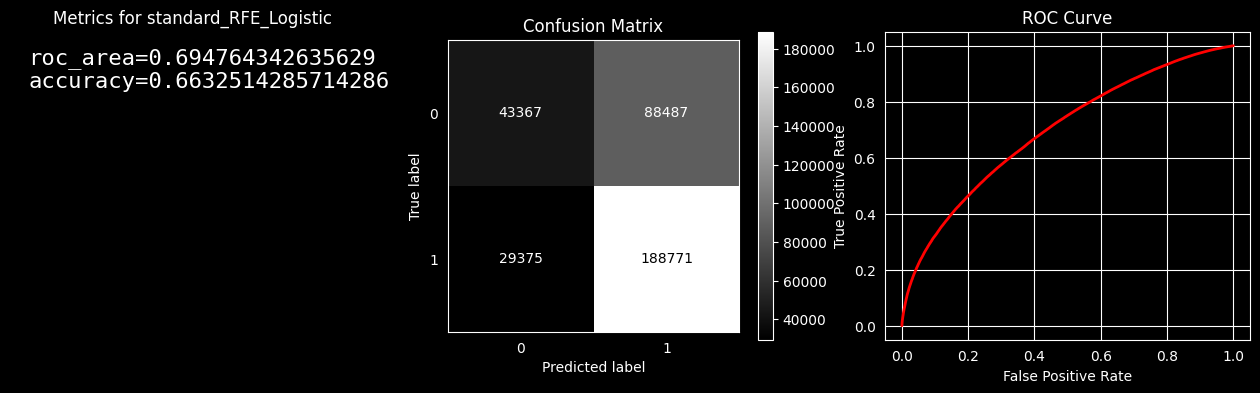

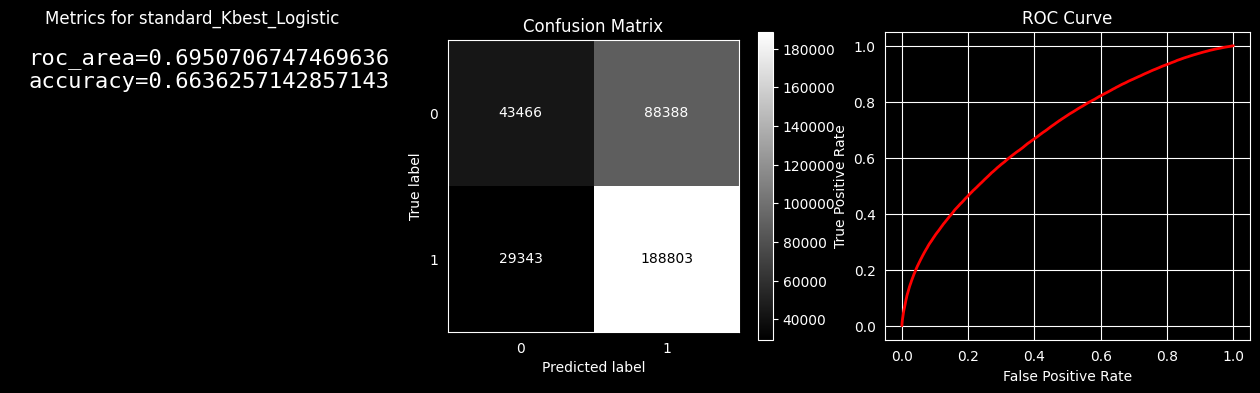

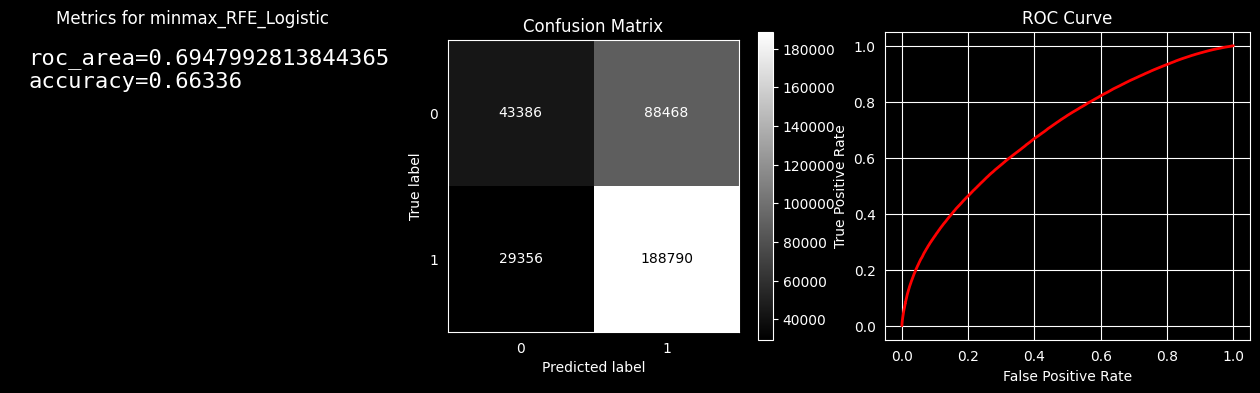

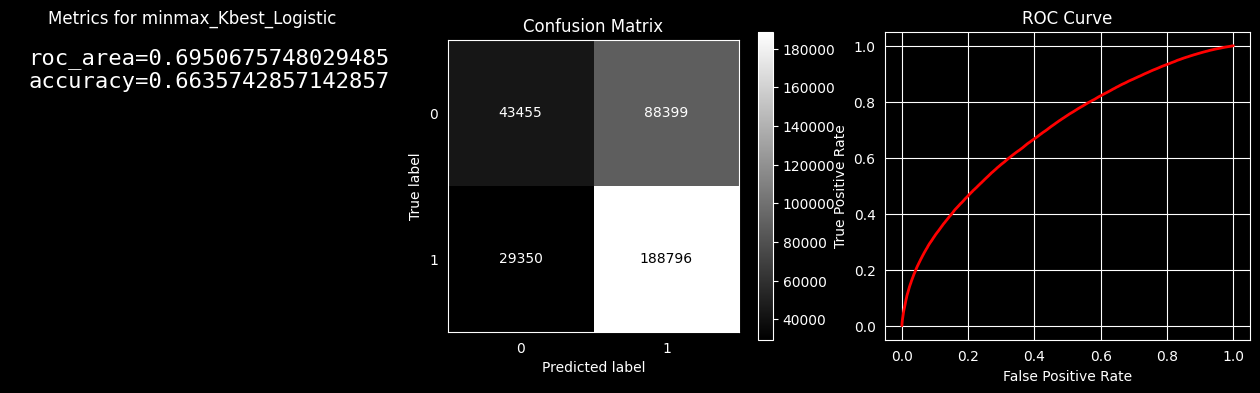

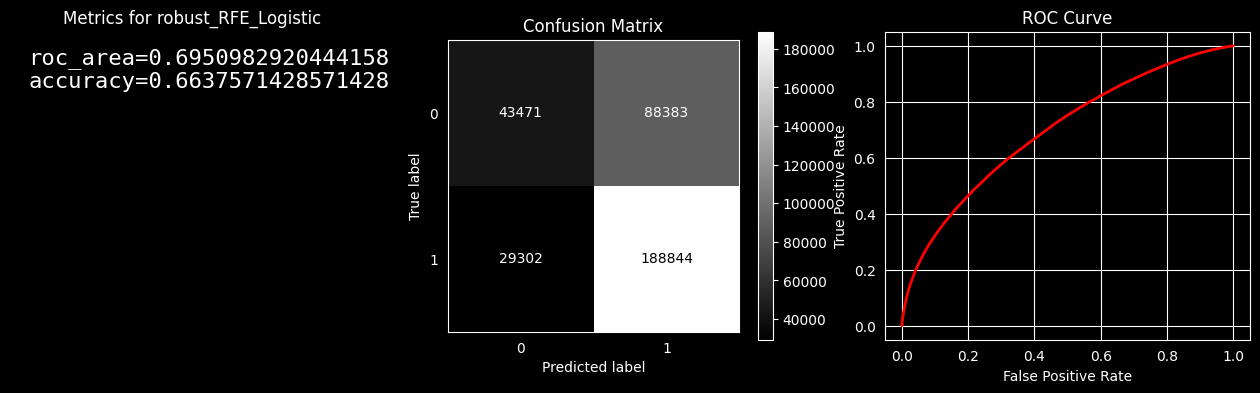

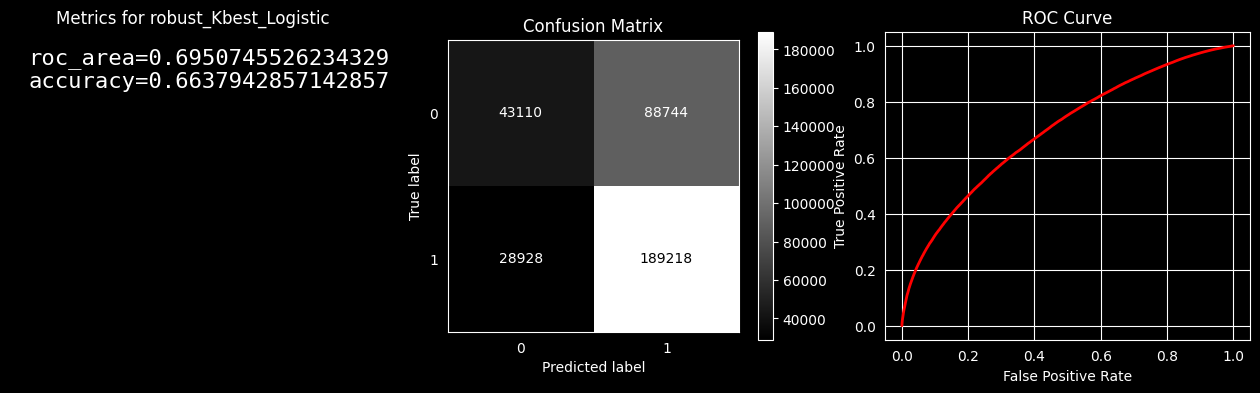

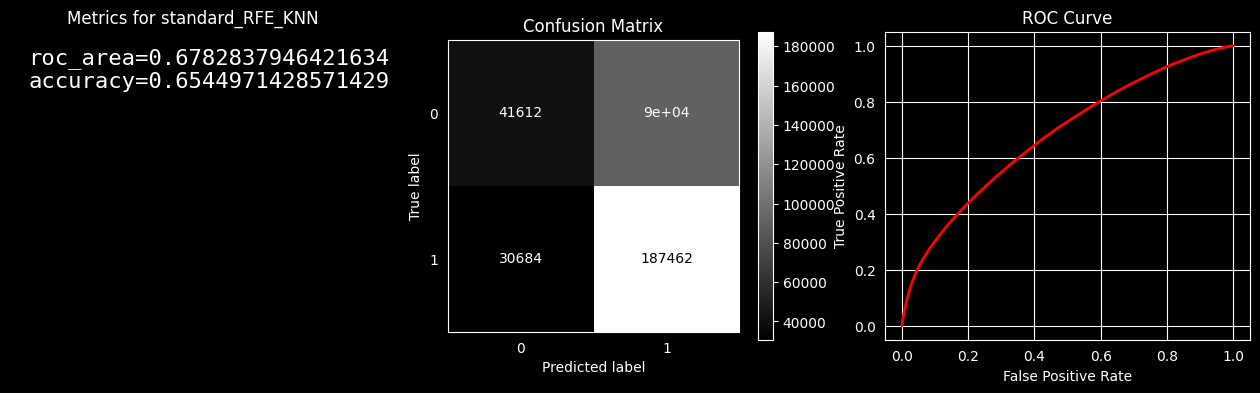

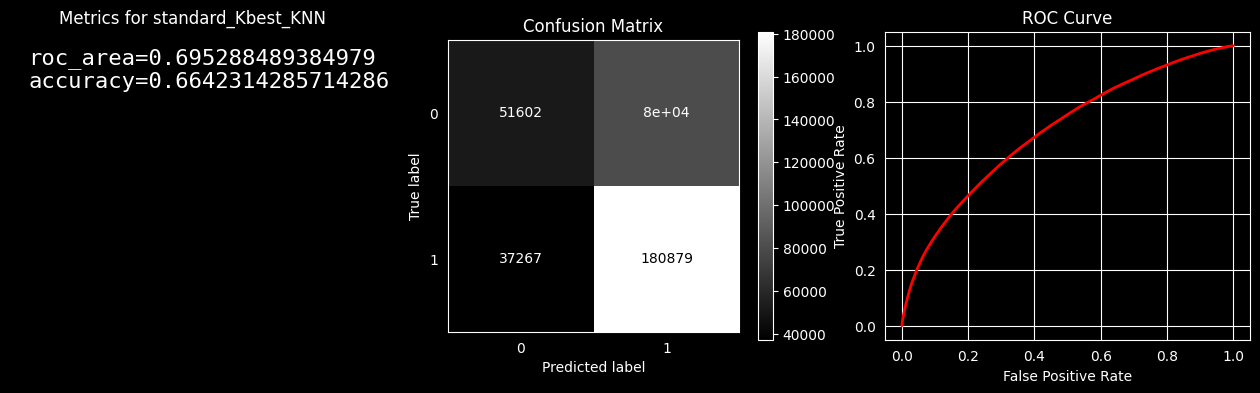

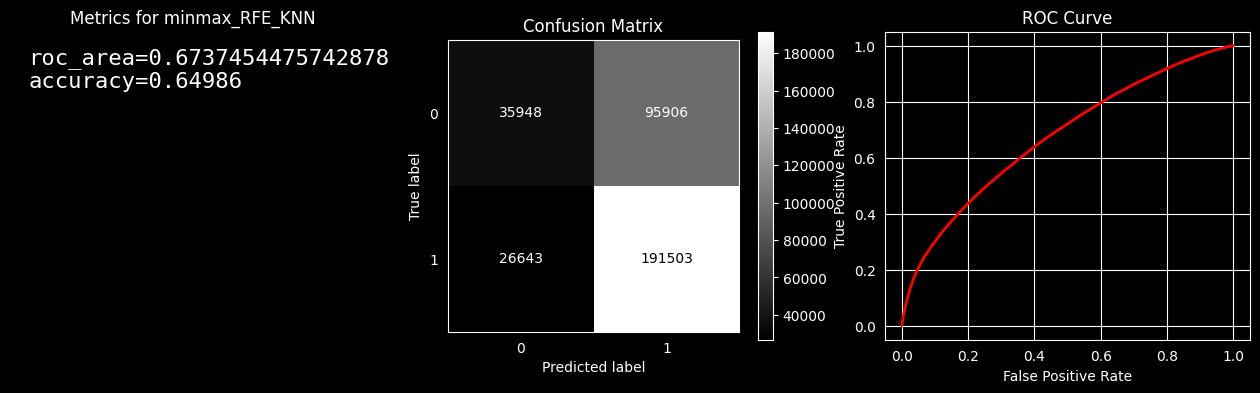

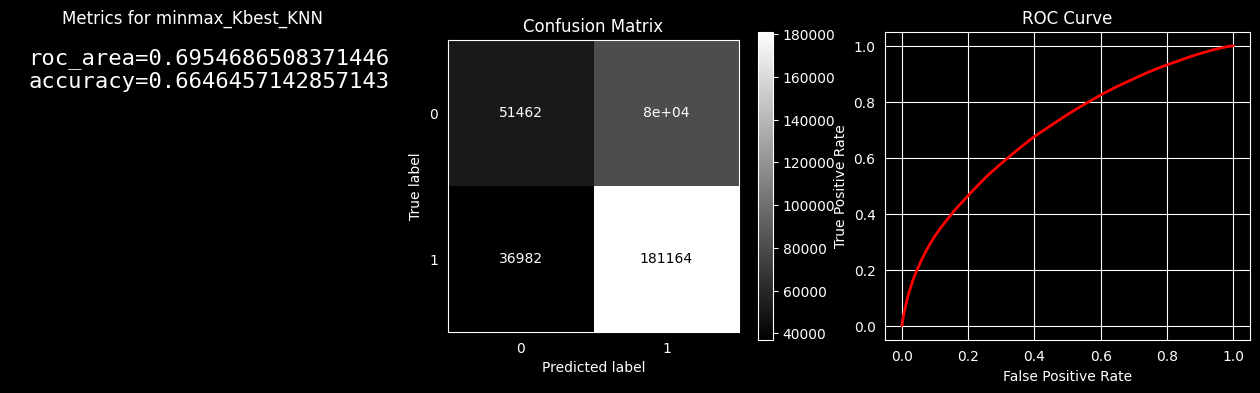

In [ ]:
import pickle

pipe_names = optim_pipes.keys()

ready_pipes = {}
results = {}
for n in pipe_names:
    print(n)
    results[n], ready_pipes[n] = optimize_train_and_judge(n, optim_pipes[n][0], optim_pipes[n][1])


    with open(f'models/{n}.pkl', 'wb') as f:
        pickle.dump(ready_pipes[n], f)

    results[n].to_csv(f'models/results_{n}.csv')
